# Импорт библиотек и модулей для расчета 

In [1]:
import numpy as np 
import sys
import os
from scipy import optimize
import CoolProp.CoolProp as CP
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from pathlib import Path
import glob


# Импорт класса расчета 
from class_DpDz import DpDz

Зададим общее количество расчетных точек

In [2]:
Nx = 50

# Исследование зависимости градиента давления от паросодерания при постоянной температуре

Вводим термодинамические параметры 

In [3]:
research_1 = {
        'Substance': 'CO2',
        'Temperature': -10,
        'x': np.linspace(0.1, 0.9, Nx),
        'G': np.array([300, 400, 500, 600])
        }

Создадим экземпляр класса расчета и зададим параметры установки 

In [4]:
first_experimental_setup = DpDz(g=9.8155, ki=None, d=0.00142, value_fb=False, thermodinamic_params=research_1)

Запишем данные расчета в df 

In [5]:
results_of_first_research = []
for idx, (G, res) in enumerate(zip(research_1['G'], first_experimental_setup.calculate())):
    df = pd.DataFrame(res)
    df['G'] = G
    results_of_first_research.append(df)

Зададим путь к папке с экспериментальными данными

In [6]:
graph_9 = Path("./Datasets/Graph9")

Запишем экспериментальные данные в df

In [7]:
exp_df_9 = []
for file_path in graph_9.rglob('*'):
    if file_path.is_file():
        try:
            write = pd.read_csv(file_path, sep='\t', decimal='.')
            exp_df_9.append(write)
        except Exception as e:
            print(f"Ошибка: {e}")

Построим графики для сравнения расчетных и экспериментальных данных 

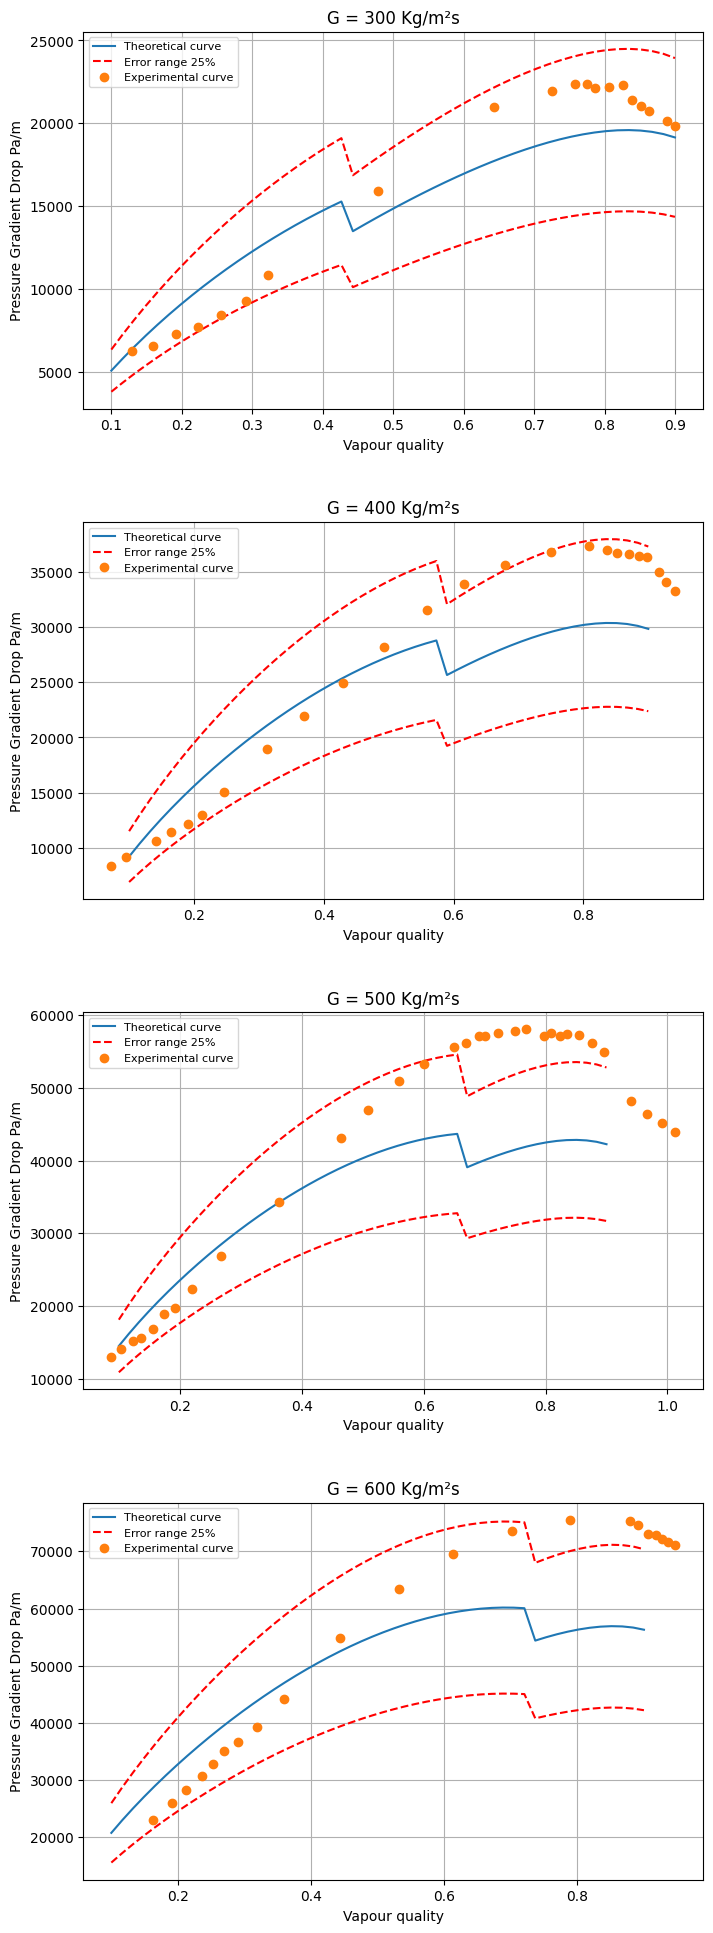

In [8]:
fig, ax = plt.subplots(nrows=len(results_of_first_research), ncols=1, figsize=(8, 24))
plt.subplots_adjust(hspace=0.3)

for i in range(len(results_of_first_research)):
    x = research_1['x']
    y = results_of_first_research[i]['DpDz']
    x_exp = exp_df_9[i]['X']
    y_exp = exp_df_9[i]['Y'] 

    ax[i].plot(x, y, label='Theoretical curve')
    ax[i].plot(x, 0.75 * y, color='red', linestyle='--', label='Error range 25%')
    ax[i].plot(x, 1.25 * y, color='red', linestyle='--')
    ax[i].plot(x_exp, y_exp * 1000, marker='o', linestyle='', label='Experimental curve')
    ax[i].set_title(f'G = {research_1["G"][i]} Kg/m²s')
    ax[i].set_xlabel('Vapour quality')
    ax[i].set_ylabel('Pressure Gradient Drop Pa/m')
    ax[i].legend(fontsize=8)
    
    ax[i].grid()


Сохранение результатов 

In [9]:

# Создаем основную папку Results если нет
os.makedirs('./Results', exist_ok=True)

for result in results_of_first_research:
    try:
        # Название вещества
        sub = result['Substance'].unique()[0]
        
        # Параметр (температура) для имени файла
        par = result['G'].unique()[0]
        
        # Директория для сохранения: Results/вещество/T
        output_dir = f'./Results/{sub}/G'
        
        # Создаем директорию если нет
        os.makedirs(output_dir, exist_ok=True)
        
        # Сохраняем каждый df с именем параметра (температуры)
        result.to_csv(f'{output_dir}/{par}.csv', index=True)
        
    except IndexError:
        print(f"Ошибка: Пустой DataFrame в results_of_second_research")
    except Exception as e:
        print(f"Ошибка при обработке данных: {e}")

# Удаляем старые файлы только после сохранения всех новых
# Или удаляем перед началом цикла (раскомментируйте нужный вариант):

# Вариант 1: Удалить все файлы в папках T перед началом
# for result in results_of_second_research:
#     sub = result['Substance'].unique()[0]
#     output_dir = f'./Results/{sub}/T'
#     if os.path.exists(output_dir):
#         for file in glob.glob(os.path.join(output_dir, '*.csv')):
#             os.remove(file)

# Вариант 2: Удалить старые файлы которые не соответствуют новым данным (рекомендуется)
existing_files = set()
for result in results_of_first_research:
    sub = result['Substance'].unique()[0]
    par = result['G'].unique()[0]
    existing_files.add(f'./Results/{sub}/T/{par}.csv')

# Удаляем файлы которых нет в новых данных
for result in results_of_first_research:
    sub = result['Substance'].unique()[0]
    output_dir = f'./Results/{sub}/T'
    if os.path.exists(output_dir):
        for file in glob.glob(os.path.join(output_dir, '*.csv')):
            if file not in existing_files:
                os.remove(file)

# Исследование зависимости градиента давления от паросодерания при постоянном расходе

Зададим путь к папке с экспериментальными данным

In [10]:
graph_12 = Path("./Datasets/Graph12")

Получим экспериментальные данные 

In [11]:
data = []
# Числовой порядок для Gr файлов
gr_files = [f for f in graph_12.rglob('Dataset*.csv')]
gr_files_sorted = sorted(gr_files, key=lambda x: int(x.stem[7:]))

for file_path in gr_files_sorted:
    if file_path.is_file():
        try:
            write = pd.read_csv(file_path, sep='\t', decimal='.')
            data.append(write)
        except Exception as e:
            print(f"Ошибка: {e}")


Зададим массив исследуемых температур

In [12]:
T = np.array([0, -10, -20, -30, -35, -40])

Изменяя параметры в цикле рассчитаем зависимость для каждой температуры

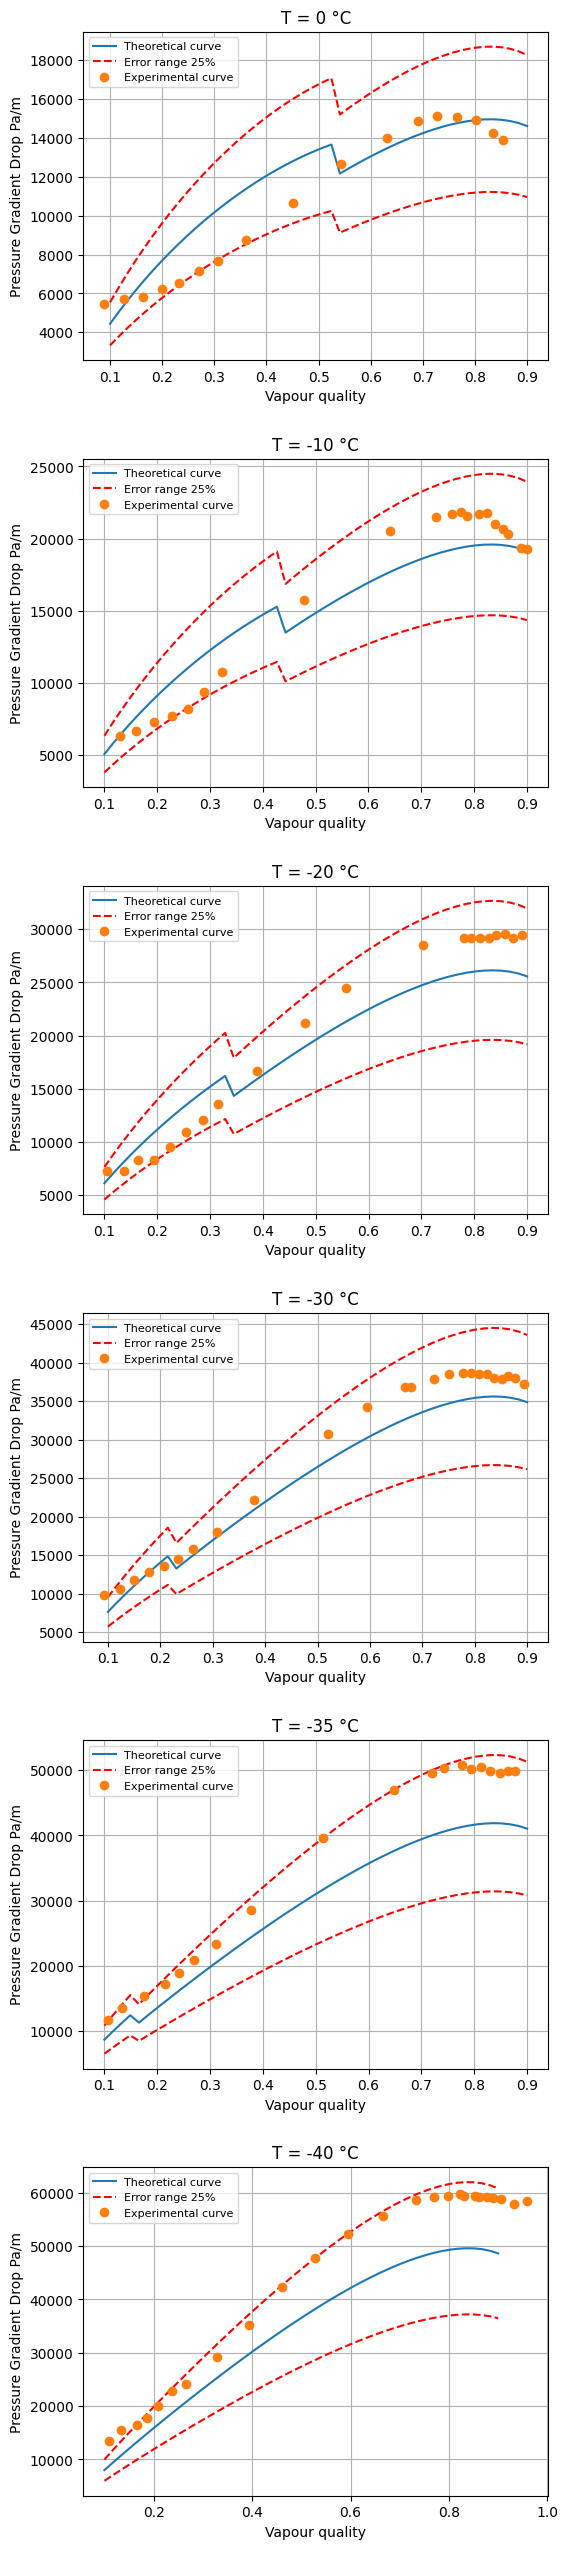

In [13]:
fig, ax = plt.subplots(nrows=len(T), ncols=1, figsize=(6, 32))
plt.subplots_adjust(hspace=0.3)
results_of_second_research = []

for i, t in enumerate(T):
    params_t = {
            'Substance': 'CO2',
            'Temperature': t,
            'G': 300,
            'x': np.linspace(0.1, 0.9, Nx),
        }
    
    second_experimental_setup = DpDz(g=9.8155, ki=None, d=0.00142, value_fb=False, thermodinamic_params=params_t)
    values = second_experimental_setup.calculate()
    
    df = pd.DataFrame(values)
    df['G'] = params_t['G']
    df['T'] = params_t['Temperature']
    results_of_second_research.append(df)

    x = params_t['x']
    y = df['DpDz']

    x_exp = data[i]['X']
    y_exp = data[i]['Y'] * 1000

    ax[i].plot(x, y, label='Theoretical curve')
    ax[i].plot(x, 0.75 * y, color='red', linestyle='--', label='Error range 25%')
    ax[i].plot(x, 1.25 * y, color='red', linestyle='--')
    ax[i].plot(x_exp, y_exp, marker='o', linestyle='', label='Experimental curve')
    ax[i].set_xlabel('Vapour quality')
    ax[i].set_ylabel('Pressure Gradient Drop Pa/m')
    ax[i].legend(fontsize=8)
    ax[i].set_title(f'T = {t} °C')
    ax[i].grid()

In [14]:

# Создаем основную папку Results если нет
os.makedirs('./Results', exist_ok=True)

for result in results_of_second_research:
    try:
        # Название вещества
        sub = result['Substance'].unique()[0]
        
        # Параметр (температура) для имени файла
        par = result['T'].unique()[0]
        
        # Директория для сохранения: Results/вещество/T
        output_dir = f'./Results/{sub}/T'
        
        # Создаем директорию если нет
        os.makedirs(output_dir, exist_ok=True)
        
        # Сохраняем каждый df с именем параметра (температуры)
        result.to_csv(f'{output_dir}/{par}.csv', index=True)
        
    except IndexError:
        print(f"Ошибка: Пустой DataFrame в results_of_second_research")
    except Exception as e:
        print(f"Ошибка при обработке данных: {e}")

# Удаляем старые файлы только после сохранения всех новых
# Или удаляем перед началом цикла (раскомментируйте нужный вариант):

# Вариант 1: Удалить все файлы в папках T перед началом
# for result in results_of_second_research:
#     sub = result['Substance'].unique()[0]
#     output_dir = f'./Results/{sub}/T'
#     if os.path.exists(output_dir):
#         for file in glob.glob(os.path.join(output_dir, '*.csv')):
#             os.remove(file)

# Вариант 2: Удалить старые файлы которые не соответствуют новым данным (рекомендуется)
existing_files = set()
for result in results_of_second_research:
    sub = result['Substance'].unique()[0]
    par = result['T'].unique()[0]
    existing_files.add(f'./Results/{sub}/T/{par}.csv')

# Удаляем файлы которых нет в новых данных
for result in results_of_second_research:
    sub = result['Substance'].unique()[0]
    output_dir = f'./Results/{sub}/T'
    if os.path.exists(output_dir):
        for file in glob.glob(os.path.join(output_dir, '*.csv')):
            if file not in existing_files:
                os.remove(file)